In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from CEVAE import *
from cevaetools import *
%load_ext autoreload
%autoreload 2

In [2]:
ihdp_train = np.load("data/IHDP/ihdp_npci_1-1000.train.npz")
for var in ihdp_train['x'][:,:,0].T:
    uniques = np.unique(var)
    if len(uniques) > 4:
        print("Num of unique vals: ", len(uniques))
    else:
        print("Unique vals: ",uniques)

Num of unique vals:  205
Num of unique vals:  43
Num of unique vals:  14
Unique vals:  [-0.87960599  0.16170253  1.20301104  2.24431956]
Num of unique vals:  85
Num of unique vals:  30
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [1. 2.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]


In [3]:
import copy
def transform_x_data(x_data):
    new_x_data = copy.deepcopy(x_data)
    #Transform the 4th variable into a categorical variable
    vals_4th_var = np.unique(x_data[:,3,:])
    val_to_idx = dict(zip(vals_4th_var, range(len(vals_4th_var))))
    vfunc = np.vectorize(lambda x: val_to_idx[x])
    new_x_data[:,3,:] = vfunc(new_x_data[:,3,:])
    
    #Transform 14th variable to regular {0,1} representation
    new_x_data[:,13,:] = new_x_data[:,13,:]-1
    
    return new_x_data
    
ihdp_x_train = transform_x_data(ihdp_train['x'])

# Load the data generator

In [4]:
from datagenVAE import GenericDataset, train_datagenerator, savemodel, loadmodel, trainZtoTmodel, dataGeneratorVAE, FullyConnected
x_dim=ihdp_x_train.shape[1]
z_dim=10
device='cpu'
x_mode=[0]*3+[4]+[0]*2+[2]*(x_dim-6)
proxymodel = loadmodel(name="proxygenerator", modeltype=dataGeneratorVAE, args=[x_dim, z_dim, device, 3, 30, 3, 30, x_mode])

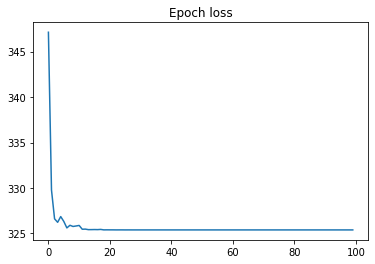

In [9]:
model_zt = trainZtoTmodel(device, ihdp_x_train[:,1,0][:,None], ihdp_train['t'][:,1][:,None], lr_start=0.05, lr_end=0.01, num_epochs=100,layers=3, width=10)

In [10]:
savemodel(model_zt, "ztotgenerator1")

In [5]:
model_zt = loadmodel("ztotgenerator4", modeltype=FullyConnected, args=[[1]+[10]*3+[1]])

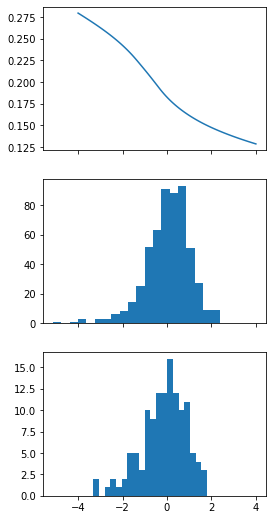

array([[0.15163713, 0.03706784],
       [0.03706784, 1.00651219]])

In [6]:
z = torch.Tensor(np.linspace(-4,4,100)[:,None])
t_pred = model_zt(z)
fig, ax = plt.subplots(3,1,figsize=(4,9), sharex=True)
ax[0].plot(z.detach(), torch.sigmoid(t_pred).detach())
ax[1].hist(ihdp_x_train[:,4,0][ihdp_train['t'][:,0]==0], bins=20)
ax[2].hist(ihdp_x_train[:,4,0][ihdp_train['t'][:,0]==1], bins=20)
plt.show()
np.cov(ihdp_train['t'][:,0], ihdp_x_train[:,0,0])

In [7]:
from datagenVAE import generatedata, rejection_sample

R squared:  0.23615423349607612
Some predictions:
[ 0.07021097  0.50627732 -0.22733489 -1.42895306  0.68433523 -0.99027939
  0.41159053 -0.20987764 -0.27294485 -1.11026099]
True values:
[ 2.330739   -1.3712213  -1.3294988  -1.0568094   1.5332116  -0.36268902
  0.48184928  1.4864223   0.14132524 -1.0727681 ]


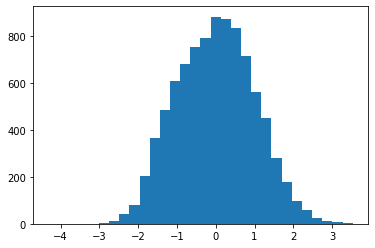

In [8]:
# Investigate how well can we predict the 1st x from the others (how much information shared)
from sklearn.ensemble import RandomForestRegressor
var_num = 5
df_screen = generatedata(10000, proxymodel, model_zt, 1, var_num)
cols = df_screen.columns.str.startswith("x")
data_x = df_screen.iloc[:,cols].to_numpy()
train_predictors = data_x[:-1000]
test_predictors = data_x[-1000:]
train_predicted = df_screen['z'].iloc[:-1000].to_numpy()#data[:-1000,var_num]
test_predicted = df_screen['z'].iloc[-1000:].to_numpy()
rf = RandomForestRegressor().fit(train_predictors, train_predicted)
print("R squared: ", rf.score(test_predictors,test_predicted))
print("Some predictions:")
print(rf.predict(test_predictors[:10,:]))
print("True values:")
print(test_predicted[:10])
plt.hist(train_predicted, bins=30)
plt.show()

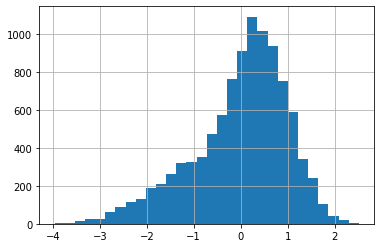

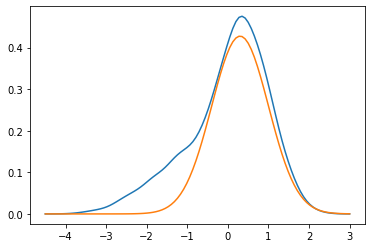

In [16]:
#Fit rejection sampling for var 1
df_screen['z'].hist(bins=30)
from sklearn.neighbors import KernelDensity
kd = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(df_screen['z'][:,None])
z_range = np.linspace(-4.5,3,100)[:,None]
density = np.exp(kd.score_samples(z_range))
plt.figure()
plt.plot(z_range,density)
from scipy.stats import norm
plt.plot(z_range,norm(loc=0.3,scale=0.7).pdf(z_range)*0.75)

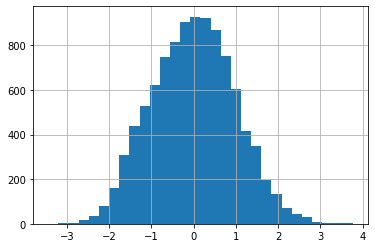

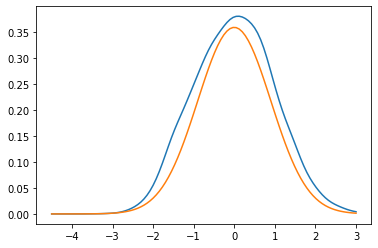

In [194]:
#Fit rejection sampling for var 5
df_screen['z'].hist(bins=30)
from sklearn.neighbors import KernelDensity
kd = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(df_screen['z'][:,None])
z_range = np.linspace(-4.5,3,100)[:,None]
density = np.exp(kd.score_samples(z_range))
plt.figure()
plt.plot(z_range,density)
from scipy.stats import norm
plt.plot(z_range,norm(loc=0.0,scale=0.9).pdf(z_range)*0.81)

In [17]:
#Var 1 rejection sampling
density_estimate_fun = lambda z: np.exp(kd.score_samples(z)).squeeze()
sample_fun = lambda z: norm(loc=0.3,scale=0.7).pdf(z)*0.75

In [200]:
#Var 5 rejection sampling
density_estimate_fun = lambda z: np.exp(kd.score_samples(z)).squeeze()
sample_fun = lambda z: norm(loc=0.0,scale=0.9).pdf(z)*0.81

# Train model with non-rejected data

In [177]:
device='cpu'
plot_curves=False
print_logs=True
num_epochs=200
lr_start=0.03
lr_end=0.001
z_dim=10
zvar_index = 5
num_samples = 20000
x_mode=np.delete(np.array([0]*3+[4]+[0]*2+[2]*(ihdp_x_train.shape[1]-6)),zvar_index)
x_dim = len(x_mode)
ATE = 1
df = generatedata(num_samples, proxymodel, model_zt, ATE, zvar_index)
dataset = CEVAEDataset(df)
train_loader = DataLoader(dataset, shuffle=True, batch_size = 200)

Epoch 0:
Sample batch loss: 3427.504638671875
Epoch loss: 352111.8447265625
x: 289889.0051269531, t: 9797.622673034668, y: 35730.927642822266, kld: 16694.29008769989
Epoch 1:
Sample batch loss: 3405.01220703125
Epoch loss: 339676.7004394531
x: 271447.2780761719, t: 9704.67115020752, y: 35433.7705078125, kld: 23090.98095703125
Epoch 2:
Sample batch loss: 3371.11181640625
Epoch loss: 338590.22607421875
x: 269609.88671875, t: 9736.460792541504, y: 35414.33694458008, kld: 23829.542053222656
Epoch 3:
Sample batch loss: 3293.5849609375
Epoch loss: 337324.4392089844
x: 267490.1662597656, t: 9680.616012573242, y: 35482.125732421875, kld: 24671.531707763672
Epoch 4:
Sample batch loss: 3347.8427734375
Epoch loss: 336426.22802734375
x: 266121.736328125, t: 9650.63394165039, y: 35482.080657958984, kld: 25171.77931213379
Epoch 5:
Sample batch loss: 3362.349609375
Epoch loss: 336160.462890625
x: 265141.7470703125, t: 9637.916000366211, y: 35522.05093383789, kld: 25858.750045776367
Epoch 6:
Sample ba

Sample batch loss: 3393.63232421875
Epoch loss: 333874.8449707031
x: 261339.20751953125, t: 9714.885627746582, y: 35335.16323852539, kld: 27485.58999633789
Epoch 51:
Sample batch loss: 3389.2626953125
Epoch loss: 334203.8068847656
x: 261886.62084960938, t: 9648.306838989258, y: 35280.803649902344, kld: 27388.07423400879
Epoch 52:
Sample batch loss: 3367.685546875
Epoch loss: 334027.41162109375
x: 261562.41235351562, t: 9656.686790466309, y: 35289.53631591797, kld: 27518.775329589844
Epoch 53:
Sample batch loss: 3338.405029296875
Epoch loss: 333753.3967285156
x: 261188.90698242188, t: 9642.676361083984, y: 35269.02908325195, kld: 27652.785751342773
Epoch 54:
Sample batch loss: 3318.652099609375
Epoch loss: 333789.28125
x: 261159.638671875, t: 9654.60474395752, y: 35284.375885009766, kld: 27690.66180419922
Epoch 55:
Sample batch loss: 3274.944091796875
Epoch loss: 333724.82421875
x: 261182.66455078125, t: 9644.388175964355, y: 35261.161865234375, kld: 27636.61001586914
Epoch 56:
Sample b

Sample batch loss: 3098.263916015625
Epoch loss: 316219.6003417969
x: 219017.193359375, t: 9619.050384521484, y: 33805.34912109375, kld: 53778.00717163086
Epoch 101:
Sample batch loss: 3169.712890625
Epoch loss: 315651.5085449219
x: 218710.75146484375, t: 9615.410934448242, y: 33779.10043334961, kld: 53546.24526977539
Epoch 102:
Sample batch loss: 3176.763671875
Epoch loss: 316138.9865722656
x: 218918.16796875, t: 9615.474884033203, y: 33822.93435668945, kld: 53782.41162109375
Epoch 103:
Sample batch loss: 3155.347412109375
Epoch loss: 316054.9616699219
x: 218563.12841796875, t: 9610.983459472656, y: 33815.46252441406, kld: 54065.388427734375
Epoch 104:
Sample batch loss: 3145.871337890625
Epoch loss: 315949.248046875
x: 218431.82470703125, t: 9619.582496643066, y: 33802.49319458008, kld: 54095.35009765625
Epoch 105:
Sample batch loss: 3193.186279296875
Epoch loss: 315837.67578125
x: 218247.08081054688, t: 9612.284729003906, y: 33783.92272949219, kld: 54194.387756347656
Epoch 106:
Samp

Sample batch loss: 3138.33056640625
Epoch loss: 314919.31884765625
x: 216615.64477539062, t: 9603.427993774414, y: 33732.52197265625, kld: 54967.71960449219
Epoch 151:
Sample batch loss: 3190.128173828125
Epoch loss: 315239.6564941406
x: 216572.2237548828, t: 9599.525016784668, y: 33737.01104736328, kld: 55330.896057128906
Epoch 152:
Sample batch loss: 3089.336181640625
Epoch loss: 315187.48828125
x: 216566.9287109375, t: 9598.172119140625, y: 33747.3274230957, kld: 55275.05877685547
Epoch 153:
Sample batch loss: 3137.375
Epoch loss: 315385.58740234375
x: 216716.541015625, t: 9607.974685668945, y: 33732.460021972656, kld: 55328.611572265625
Epoch 154:
Sample batch loss: 3218.6787109375
Epoch loss: 315261.4362792969
x: 216733.36987304688, t: 9606.12409210205, y: 33720.72348022461, kld: 55201.218994140625
Epoch 155:
Sample batch loss: 3075.42822265625
Epoch loss: 315053.591796875
x: 216603.31005859375, t: 9598.985359191895, y: 33735.582275390625, kld: 55115.714599609375
Epoch 156:
Sample

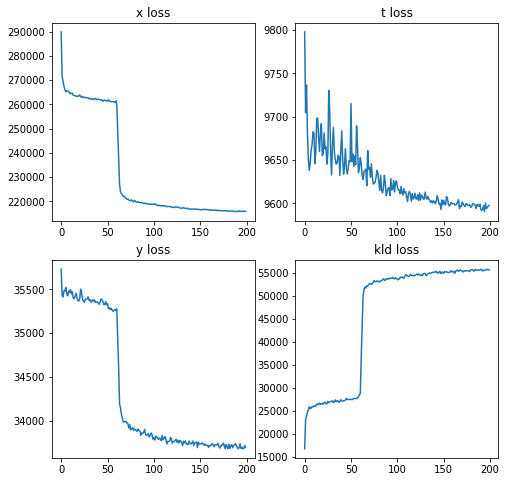

Total loss in the end:  314968.392578125


In [178]:
from cevaetools import train_model
model, losses = train_model(device, plot_curves, print_logs,
              train_loader, num_epochs, lr_start, lr_end, x_dim, z_dim,
              p_y_zt_nn_layers=3, p_y_zt_nn_width=30, 
              p_t_z_nn_layers=3, p_t_z_nn_width=30,
              p_x_z_nn_layers=3, p_x_z_nn_width=30,
              q_z_nn_layers=3, q_z_nn_width=30,
              t_mode=2, y_mode=0, x_mode=x_mode, ty_separate_enc=True)

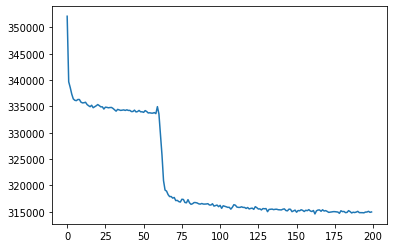

In [179]:
plt.plot(losses['total'])

In [182]:
estimate_model_py_dot(model,200000)

array([0.02325137, 0.91036814])

In [184]:
from sklearn.linear_model import LinearRegression
lr1 = LinearRegression().fit(df['z'][df['t']==1].to_numpy()[:,None],df['y'][df['t']==1].to_numpy()[:,None])
lr0 = LinearRegression().fit(df['z'][df['t']==0].to_numpy()[:,None],df['y'][df['t']==0].to_numpy()[:,None])
print(lr1.predict(df['z'][:,None]).mean())
print(lr0.predict(df['z'][:,None]).mean())

0.9998201
0.0010404526


In [185]:
from sklearn.ensemble import RandomForestRegressor
cols = df.columns.str.startswith("x")
rf1 = RandomForestRegressor().fit(df.iloc[:,cols].loc[df.t==1], df["y"][df.t==1])
rf0 = RandomForestRegressor().fit(df.iloc[:,cols].loc[df.t==0], df["y"][df.t==0])
print(rf1.predict(df.iloc[:,cols]).mean())
print(rf0.predict(df.iloc[:,cols]).mean())

0.9006799564241266
0.02298084975284986


# Train model with rejection sampled data

In [ ]:
1.295203
0.2871502
1.2900878
0.29673052
1.2854105
0.28751454

In [128]:
df = generatedata(20000, proxymodel, model_zt, ATE, zvar_index)
df_r = rejection_sample(df, density_estimate_fun, sample_fun)
from sklearn.linear_model import LinearRegression
lr1 = LinearRegression().fit(df_r['z'][df_r['t']==1].to_numpy()[:,None],df_r['y'][df_r['t']==1].to_numpy()[:,None])
lr0 = LinearRegression().fit(df_r['z'][df_r['t']==0].to_numpy()[:,None],df_r['y'][df_r['t']==0].to_numpy()[:,None])
print(lr1.predict(df_r['z'][:,None]).mean())
print(lr0.predict(df_r['z'][:,None]).mean())

1.2854105
0.28751454


In [201]:
df = generatedata(26000, proxymodel, model_zt, ATE, zvar_index)
df_r = rejection_sample(df, density_estimate_fun, sample_fun)
dataset = CEVAEDataset(df_r)
train_loader = DataLoader(dataset, shuffle=True, batch_size = 200)

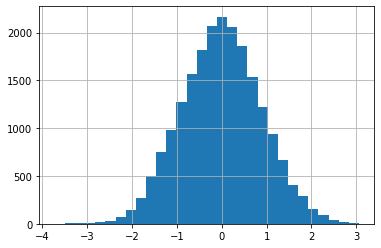

In [203]:
df_r['z'].hist(bins=30)

Epoch 0:
Sample batch loss: 3400.43408203125
Epoch loss: 369252.6789550781
x: 307445.85888671875, t: 10240.686424255371, y: 36361.55880737305, kld: 15204.575330257416
Epoch 1:
Sample batch loss: 3364.474609375
Epoch loss: 355253.0881347656
x: 285577.8649902344, t: 10065.411041259766, y: 36016.22561645508, kld: 23593.58494567871
Epoch 2:
Sample batch loss: 3331.30322265625
Epoch loss: 352303.5295410156
x: 280693.7038574219, t: 10089.054229736328, y: 35969.45458984375, kld: 25551.31672668457
Epoch 3:
Sample batch loss: 3388.6953125
Epoch loss: 352868.9079589844
x: 281332.74365234375, t: 10081.070343017578, y: 36026.54345703125, kld: 25428.55014038086
Epoch 4:
Sample batch loss: 3298.761474609375
Epoch loss: 351885.93798828125
x: 280023.4501953125, t: 10092.169921875, y: 36066.819763183594, kld: 25703.49885559082
Epoch 5:
Sample batch loss: 3380.563232421875
Epoch loss: 351224.921875
x: 279007.3620605469, t: 10079.62427520752, y: 36014.52993774414, kld: 26123.40594482422
Epoch 6:
Sample b

Sample batch loss: 3376.97998046875
Epoch loss: 348944.94921875
x: 274324.90380859375, t: 10089.787658691406, y: 35919.22677612305, kld: 28611.031051635742
Epoch 51:
Sample batch loss: 3302.39990234375
Epoch loss: 349092.2707519531
x: 274541.0751953125, t: 10085.299591064453, y: 35905.33923339844, kld: 28560.55601501465
Epoch 52:
Sample batch loss: 3327.990478515625
Epoch loss: 348869.4382324219
x: 274416.2429199219, t: 10066.321258544922, y: 35903.73028564453, kld: 28483.14419555664
Epoch 53:
Sample batch loss: 3334.6787109375
Epoch loss: 348945.5925292969
x: 274363.23095703125, t: 10059.693664550781, y: 35881.77066040039, kld: 28640.895965576172
Epoch 54:
Sample batch loss: 3348.55615234375
Epoch loss: 348783.0134277344
x: 274392.33984375, t: 10077.277709960938, y: 35879.860778808594, kld: 28433.53514099121
Epoch 55:
Sample batch loss: 3359.140625
Epoch loss: 348934.2451171875
x: 274293.12060546875, t: 10069.512702941895, y: 35886.47299194336, kld: 28685.138412475586
Epoch 56:
Sample

Sample batch loss: 3283.31396484375
Epoch loss: 347868.27587890625
x: 273095.287109375, t: 10045.881164550781, y: 35864.98452758789, kld: 28862.122344970703
Epoch 101:
Sample batch loss: 3311.931884765625
Epoch loss: 347986.6735839844
x: 273130.4775390625, t: 10049.178993225098, y: 35860.864990234375, kld: 28946.15200805664
Epoch 102:
Sample batch loss: 3302.358642578125
Epoch loss: 348225.54052734375
x: 273185.7626953125, t: 10043.015319824219, y: 35862.83279418945, kld: 29133.931121826172
Epoch 103:
Sample batch loss: 3316.351806640625
Epoch loss: 348003.4982910156
x: 272984.4365234375, t: 10042.141494750977, y: 35869.5078125, kld: 29107.41096496582
Epoch 104:
Sample batch loss: 3303.99560546875
Epoch loss: 348095.53662109375
x: 273128.65771484375, t: 10041.96647644043, y: 35869.7333984375, kld: 29055.178771972656
Epoch 105:
Sample batch loss: 3312.16357421875
Epoch loss: 348086.7978515625
x: 272903.0158691406, t: 10044.322761535645, y: 35863.23400878906, kld: 29276.226623535156
Epoc

Sample batch loss: 3262.306396484375
Epoch loss: 347588.2121582031
x: 272183.6667480469, t: 10036.234649658203, y: 35784.290100097656, kld: 29584.020141601562
Epoch 150:
Sample batch loss: 3305.263671875
Epoch loss: 347468.1823730469
x: 272309.2790527344, t: 10036.949745178223, y: 35783.45944213867, kld: 29338.49429321289
Epoch 151:
Sample batch loss: 3342.940185546875
Epoch loss: 347548.06494140625
x: 272274.6271972656, t: 10036.920860290527, y: 35782.852447509766, kld: 29453.664749145508
Epoch 152:
Sample batch loss: 3362.60009765625
Epoch loss: 347370.6867675781
x: 272345.6611328125, t: 10037.475791931152, y: 35767.02462768555, kld: 29220.52667236328
Epoch 153:
Sample batch loss: 3335.58740234375
Epoch loss: 347289.9396972656
x: 272193.4553222656, t: 10037.903816223145, y: 35778.14144897461, kld: 29280.440338134766
Epoch 154:
Sample batch loss: 3288.336181640625
Epoch loss: 347656.93310546875
x: 272349.8557128906, t: 10038.291198730469, y: 35774.63131713867, kld: 29494.15594482422
E

Sample batch loss: 3232.647705078125
Epoch loss: 347131.14501953125
x: 271506.55859375, t: 10034.969673156738, y: 35741.21649169922, kld: 29848.399505615234


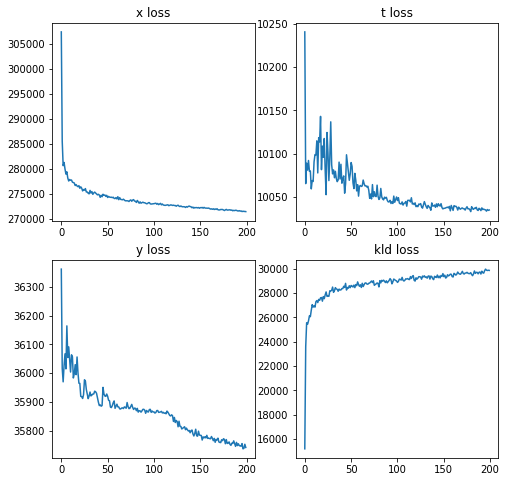

Total loss in the end:  347131.14501953125


In [204]:
from cevaetools import train_model
model2, losses2 = train_model(device, plot_curves, print_logs,
              train_loader, num_epochs, lr_start, lr_end, x_dim, z_dim,
              p_y_zt_nn_layers=3, p_y_zt_nn_width=30, 
              p_t_z_nn_layers=3, p_t_z_nn_width=30,
              p_x_z_nn_layers=3, p_x_z_nn_width=30,
              q_z_nn_layers=3, q_z_nn_width=30,
              t_mode=2, y_mode=0, x_mode=x_mode, ty_separate_enc=True)

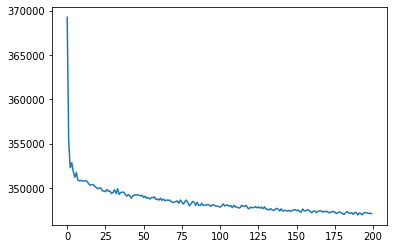

In [205]:
plt.plot(losses2['total'])

In [210]:
estimate_model_py_dot(model2, 200000)

array([0.01653392, 0.88492453])

In [31]:
len(df_r)

9774

# Train model with non-rejected data, add extra gaussian x

In [110]:
device='cpu'
plot_curves=False
print_logs=True
num_epochs=200
lr_start=0.01
lr_end=0.001
z_dim=1
zvar_index = 5
num_samples = 20000
x_mode=np.delete(np.array([0]*3+[4]+[0]*2+[2]*(ihdp_x_train.shape[1]-6)),zvar_index)
#x_mode=np.delete(np.array([0]*3+[0]+[0]*2+[0]*(ihdp_x_train.shape[1]-6) + [0]*0),zvar_index)
x_dim = len(x_mode)
ATE = 1
df = generatedata(num_samples, proxymodel, model_zt, ATE, zvar_index)
#df['x24'] = df['z'] + np.random.randn(20000)
#df[['x'+str(i) for i in range(24)]] += 1*np.random.randn(20000,24)
#df['x25'] = df['z'] + np.random.randn(20000)

In [111]:
dataset = CEVAEDataset(df)
train_loader = DataLoader(dataset, shuffle=True, batch_size = 200)

Epoch 0:
Sample batch loss: 3373.50390625
Epoch loss: 346328.3635253906
x: 281504.6552734375, t: 9669.34782409668, y: 35490.438079833984, kld: 19663.923238813877
Epoch 1:
Sample batch loss: 3327.9365234375
Epoch loss: 336029.7233886719
x: 267340.42724609375, t: 9550.801246643066, y: 35376.857482910156, kld: 23761.63818359375
Epoch 2:
Sample batch loss: 3376.98388671875
Epoch loss: 334051.216796875
x: 263928.6240234375, t: 9532.340530395508, y: 35338.30194091797, kld: 25251.94871520996
Epoch 3:
Sample batch loss: 3442.485107421875
Epoch loss: 334282.41748046875
x: 264136.7412109375, t: 9526.857582092285, y: 35340.89782714844, kld: 25277.918701171875
Epoch 4:
Sample batch loss: 3330.442138671875
Epoch loss: 333991.3908691406
x: 263830.99609375, t: 9531.647682189941, y: 35311.816650390625, kld: 25316.929565429688
Epoch 5:
Sample batch loss: 3417.88037109375
Epoch loss: 333618.5263671875
x: 262890.333984375, t: 9529.786003112793, y: 35302.70440673828, kld: 25895.702407836914
Epoch 6:
Sampl

Sample batch loss: 3245.5
Epoch loss: 332047.37255859375
x: 259666.6640625, t: 9519.538787841797, y: 35210.99328613281, kld: 27650.17724609375
Epoch 51:
Sample batch loss: 3336.433349609375
Epoch loss: 331873.7883300781
x: 259697.82421875, t: 9519.27426147461, y: 35213.104736328125, kld: 27443.584259033203
Epoch 52:
Sample batch loss: 3313.720703125
Epoch loss: 331806.998046875
x: 259590.19311523438, t: 9522.542236328125, y: 35217.429107666016, kld: 27476.83332824707
Epoch 53:
Sample batch loss: 3265.107421875
Epoch loss: 331786.8029785156
x: 259177.11499023438, t: 9528.174819946289, y: 35211.74392700195, kld: 27869.77117919922
Epoch 54:
Sample batch loss: 3326.3525390625
Epoch loss: 331799.13720703125
x: 259637.4404296875, t: 9525.41675567627, y: 35227.10534667969, kld: 27409.173904418945
Epoch 55:
Sample batch loss: 3303.520263671875
Epoch loss: 331795.3825683594
x: 259425.55053710938, t: 9518.899574279785, y: 35214.26205444336, kld: 27636.668655395508
Epoch 56:
Sample batch loss: 32

Sample batch loss: 3423.558349609375
Epoch loss: 330546.8947753906
x: 255521.68090820312, t: 9516.67765045166, y: 35151.52526855469, kld: 30357.0126953125
Epoch 101:
Sample batch loss: 3220.673583984375
Epoch loss: 330395.15966796875
x: 255511.8720703125, t: 9516.622192382812, y: 35174.172424316406, kld: 30192.49301147461
Epoch 102:
Sample batch loss: 3286.361328125
Epoch loss: 330134.4990234375
x: 254961.73754882812, t: 9517.807029724121, y: 35156.69998168945, kld: 30498.255340576172
Epoch 103:
Sample batch loss: 3256.886474609375
Epoch loss: 330425.4931640625
x: 255184.33520507812, t: 9516.752166748047, y: 35174.425842285156, kld: 30549.980438232422
Epoch 104:
Sample batch loss: 3305.634521484375
Epoch loss: 330287.8249511719
x: 254886.611328125, t: 9517.493446350098, y: 35174.897033691406, kld: 30708.823333740234
Epoch 105:
Sample batch loss: 3294.88525390625
Epoch loss: 330339.97216796875
x: 254850.85327148438, t: 9513.77059173584, y: 35191.16632080078, kld: 30784.17950439453
Epoch

Sample batch loss: 3349.292724609375
Epoch loss: 328295.0158691406
x: 248838.44799804688, t: 9515.293296813965, y: 34691.884857177734, kld: 35249.39077758789
Epoch 151:
Sample batch loss: 3255.63232421875
Epoch loss: 327994.25048828125
x: 248673.58471679688, t: 9515.324745178223, y: 34643.07751464844, kld: 35162.26321411133
Epoch 152:
Sample batch loss: 3260.6748046875
Epoch loss: 328137.6630859375
x: 248722.50732421875, t: 9514.213836669922, y: 34622.49938964844, kld: 35278.44418334961
Epoch 153:
Sample batch loss: 3337.372314453125
Epoch loss: 328045.6516113281
x: 248619.8759765625, t: 9513.395225524902, y: 34649.42404174805, kld: 35262.956970214844
Epoch 154:
Sample batch loss: 3272.72802734375
Epoch loss: 327796.4826660156
x: 248465.72143554688, t: 9513.51010131836, y: 34671.635650634766, kld: 35145.614501953125
Epoch 155:
Sample batch loss: 3283.07470703125
Epoch loss: 328409.9699707031
x: 248628.140625, t: 9512.040283203125, y: 34608.225677490234, kld: 35661.561767578125
Epoch 15

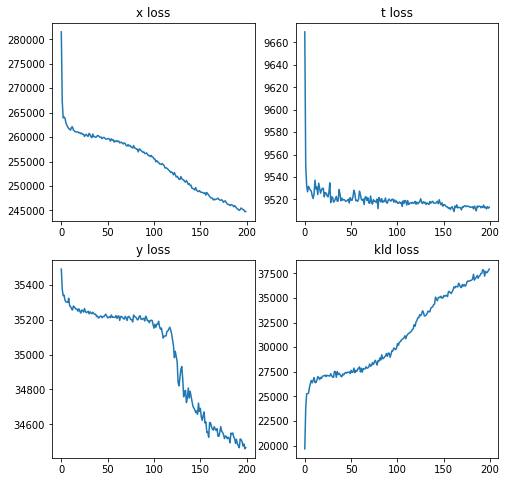

Total loss in the end:  326710.5979003906


In [112]:
from cevaetools import train_model
model, losses = train_model(device, plot_curves, print_logs,
              train_loader, num_epochs, lr_start, lr_end, x_dim, z_dim,
              p_y_zt_nn_layers=3, p_y_zt_nn_width=30, 
              p_t_z_nn_layers=3, p_t_z_nn_width=30,
              p_x_z_nn_layers=3, p_x_z_nn_width=30,
              q_z_nn_layers=3, q_z_nn_width=30,
              t_mode=2, y_mode=0, x_mode=x_mode, ty_separate_enc=True)

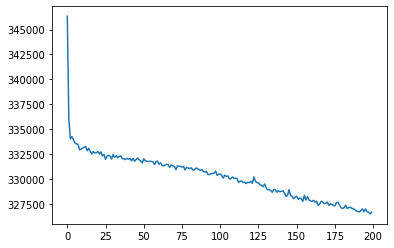

In [113]:
plt.plot(losses['total'])

In [114]:
estimate_model_py_dot(model, 200000)

array([0.02739802, 0.89708352])

In [99]:
from sklearn.ensemble import RandomForestRegressor
cols = df.columns.str.startswith("x")
rf1 = RandomForestRegressor().fit(df.iloc[:,cols].loc[df.t==1], df["y"][df.t==1])
rf0 = RandomForestRegressor().fit(df.iloc[:,cols].loc[df.t==0], df["y"][df.t==0])
print(rf1.predict(df.iloc[:,cols]).mean())
print(rf0.predict(df.iloc[:,cols]).mean())

0.9070660673654971
0.030669432079427697


# Train model with non-rejected data, loss scaling

In [203]:
device='cpu'
plot_curves=False
print_logs=True
num_epochs=200
lr_start=0.001
lr_end=0.00001
z_dim=10
zvar_index = 5
num_samples = 10000
x_mode=np.delete(np.array([0]*3+[4]+[0]*2+[2]*(ihdp_x_train.shape[1]-6)),zvar_index)
x_dim = len(x_mode)
ATE = 0.5
df = generatedata(num_samples, proxymodel, model_zt, ATE, zvar_index)

In [187]:
dataset = CEVAEDataset(df)
train_loader = DataLoader(dataset, shuffle=True, batch_size = 200)

Epoch 0:
Epoch loss: 210227.68017578125
x: 186111.35327148438, t: 5844.861633300781, y: 17750.504608154297, kld: 520.9605355262756
Epoch 1:
Epoch loss: 181515.82153320312
x: 158777.82543945312, t: 4818.526336669922, y: 17519.488525390625, kld: 399.98189401626587
Epoch 2:
Epoch loss: 178416.2412109375
x: 154631.90893554688, t: 4796.317687988281, y: 17509.307891845703, kld: 1478.7065424919128
Epoch 3:
Epoch loss: 175252.51708984375
x: 146932.16259765625, t: 4809.07795715332, y: 17513.89093017578, kld: 5997.385299682617
Epoch 4:
Epoch loss: 173011.39794921875
x: 142645.208984375, t: 4801.080993652344, y: 17500.835357666016, kld: 8064.273300170898
Epoch 5:
Epoch loss: 168826.13891601562
x: 135636.28637695312, t: 4811.250442504883, y: 17509.383697509766, kld: 10869.218017578125
Epoch 6:
Epoch loss: 168092.12841796875
x: 134097.21313476562, t: 4808.443145751953, y: 17498.447021484375, kld: 11688.024719238281
Epoch 7:
Epoch loss: 167852.30981445312
x: 133604.82104492188, t: 4804.209037780762,

Epoch loss: 166091.90942382812
x: 129747.615234375, t: 4803.293151855469, y: 17384.851623535156, kld: 14156.150299072266
Epoch 64:
Epoch loss: 166109.78637695312
x: 129889.36181640625, t: 4802.107704162598, y: 17367.312591552734, kld: 14051.003875732422
Epoch 65:
Epoch loss: 166072.763671875
x: 129725.63720703125, t: 4803.92684173584, y: 17387.188079833984, kld: 14156.01171875
Epoch 66:
Epoch loss: 166091.54541015625
x: 129713.56420898438, t: 4802.253211975098, y: 17352.797271728516, kld: 14222.931091308594
Epoch 67:
Epoch loss: 166033.85034179688
x: 129703.66625976562, t: 4803.345359802246, y: 17344.062591552734, kld: 14182.776733398438
Epoch 68:
Epoch loss: 166051.892578125
x: 129681.81616210938, t: 4803.436325073242, y: 17337.898559570312, kld: 14228.74267578125
Epoch 69:
Epoch loss: 166153.44970703125
x: 129676.13403320312, t: 4802.995079040527, y: 17323.924255371094, kld: 14350.39682006836
Epoch 70:
Epoch loss: 166067.22119140625
x: 129594.41333007812, t: 4801.643760681152, y: 173

Epoch loss: 165090.97875976562
x: 126592.8603515625, t: 4798.953704833984, y: 16947.480560302734, kld: 16751.683197021484
Epoch 127:
Epoch loss: 164901.47192382812
x: 126405.52416992188, t: 4800.658378601074, y: 16978.252166748047, kld: 16717.037567138672
Epoch 128:
Epoch loss: 164901.39721679688
x: 126458.78466796875, t: 4790.711784362793, y: 16962.25131225586, kld: 16689.648834228516
Epoch 129:
Epoch loss: 165023.65576171875
x: 126631.49487304688, t: 4792.482765197754, y: 16971.031005859375, kld: 16628.64581298828
Epoch 130:
Epoch loss: 164941.02709960938
x: 126459.52368164062, t: 4793.280235290527, y: 16954.943084716797, kld: 16733.280670166016
Epoch 131:
Epoch loss: 164946.33618164062
x: 126440.82543945312, t: 4799.439842224121, y: 16982.43618774414, kld: 16723.635498046875
Epoch 132:
Epoch loss: 165094.75219726562
x: 126608.04125976562, t: 4798.004219055176, y: 16946.011596679688, kld: 16742.695373535156
Epoch 133:
Epoch loss: 165014.59497070312
x: 126480.68286132812, t: 4798.4375

Epoch loss: 164738.49169921875
x: 126094.130859375, t: 4793.591438293457, y: 16962.379150390625, kld: 16888.389892578125
Epoch 189:
Epoch loss: 164985.75341796875
x: 126351.31811523438, t: 4796.074043273926, y: 16953.971710205078, kld: 16884.389068603516
Epoch 190:
Epoch loss: 164918.14526367188
x: 126261.99145507812, t: 4799.02424621582, y: 16932.580169677734, kld: 16924.549255371094
Epoch 191:
Epoch loss: 165110.90185546875
x: 126447.80419921875, t: 4795.672348022461, y: 16954.76739501953, kld: 16912.658905029297
Epoch 192:
Epoch loss: 164954.2177734375
x: 126271.96606445312, t: 4797.965087890625, y: 16963.95849609375, kld: 16920.327758789062
Epoch 193:
Epoch loss: 164786.8974609375
x: 126122.83325195312, t: 4798.483573913574, y: 16929.180084228516, kld: 16936.401916503906
Epoch 194:
Epoch loss: 165021.8408203125
x: 126311.98266601562, t: 4796.1795654296875, y: 17006.42074584961, kld: 16907.257843017578
Epoch 195:
Epoch loss: 164622.95239257812
x: 126062.39672851562, t: 4800.25723266

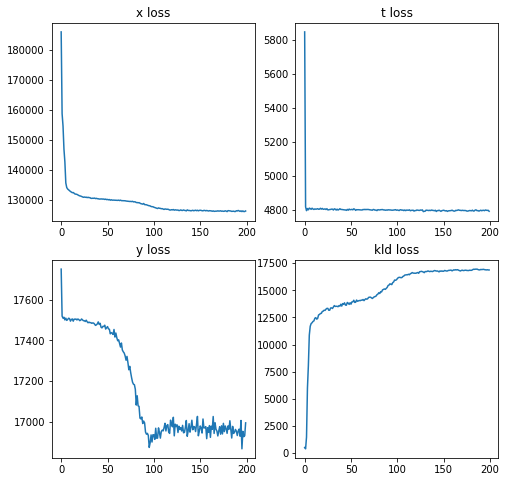

Total loss in the end:  164933.10180664062


In [204]:
from cevaetools import train_model
model, losses = train_model(device, plot_curves, print_logs,
              train_loader, num_epochs, lr_start, lr_end, x_dim, z_dim,
              p_y_zt_nn_layers=3, p_y_zt_nn_width=30, 
              p_t_z_nn_layers=3, p_t_z_nn_width=30,
              p_x_z_nn_layers=3, p_x_z_nn_width=30,
              q_z_nn_layers=3, q_z_nn_width=30,
              t_mode=2, y_mode=0, x_mode=x_mode, ty_separate_enc=True, x_loss_scaling=1)

In [205]:
estimate_model_py_dot(model, 200000)

array([0.03373456, 0.38849953])

In [198]:
from sklearn.ensemble import RandomForestRegressor
cols = df.columns.str.startswith("x")
rf1 = RandomForestRegressor().fit(df.iloc[:,cols].loc[df.t==1], df["y"][df.t==1])
rf0 = RandomForestRegressor().fit(df.iloc[:,cols].loc[df.t==0], df["y"][df.t==0])
print(rf1.predict(df.iloc[:,cols]).mean())
print(rf0.predict(df.iloc[:,cols]).mean())

0.40687875882316815
0.026276368645850885


In [197]:
print(df[df['t']==1]['y'].mean())
print(df[df['t']==0]['y'].mean())

0.3655035
0.03693618


- Jos voisi osoittaa, että x lossia skaalatessa nollasta ylöspäin jossain vaiheessa tapahtuu äkkinäinen muutos posteriorin käytössä, niin sehän voisi tavallaan olla ehto sille, että ollaanko otettu proxyt oikein huomioon

# Run the loss scaled model multiple times to figure out the loss scaling

### Generate data set

In [179]:
# Generate data sets
main_folder = "realdataz5"
sub_folder = "ATE0.5samplesize10000times10"
ATE = 0.5
zvar_index = 5
dataparameters = [10000, proxymodel, model_zt, ATE, zvar_index]
generate_df = generatedata
param_times=10

In [180]:
dfs, datasets = create_dfs_datasets(generate_df, [dataparameters], param_times=10, repeat=True, 
                    main_folder=main_folder, sub_folder=sub_folder, labels=["df10000"])

Creation of the directory './data/realdataz5/ATE0.5samplesize10000times10/ failed. Trying to empty the same folder.


In [181]:
dfs, datasets = load_dfs(main_folder, sub_folder, param_times)

In [182]:
datasets.keys()

dict_keys(['df10000'])

### Run model

In [183]:
BATCH_SIZE = 200
track_function = lambda model: estimate_model_py_dot(model, 200000)
true_value = [0,0.5]
device = 'cpu'

num_epochs=200
lr_start=0.001
lr_end=0.00001
z_dim=1
p_y_zt_nn_layers=3
p_y_zt_nn_width=30
p_t_z_nn_layers=3
p_t_z_nn_width=30
p_x_z_nn_layers=3
p_x_z_nn_width=30
q_z_nn_layers=3
q_z_nn_width=30
t_mode=2
y_mode=0
x_mode=np.delete(np.array([0]*3+[4]+[0]*2+[2]*(ihdp_x_train.shape[1]-6)),zvar_index)
x_dim = len(x_mode)
ty_separate_enc=True
z_mode=0
x_loss_scaling=[1,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]

train_arguments = [num_epochs, lr_start, lr_end, x_dim, z_dim,
                p_y_zt_nn_layers, p_y_zt_nn_width, 
                p_t_z_nn_layers, p_t_z_nn_width,
                p_x_z_nn_layers, p_x_z_nn_width,
                q_z_nn_layers, q_z_nn_width, t_mode, y_mode,
                x_mode, ty_separate_enc, z_mode, x_loss_scaling]

sub_folder_model = "ATE0.5samplesize10000modelsscalings"
labels = x_loss_scaling
data_labels = ["df10000"]*10

Creation of the directory './data/realdataz5/ATE0.5samplesize10000modelsscalings/ failed. Trying to empty the same folder.


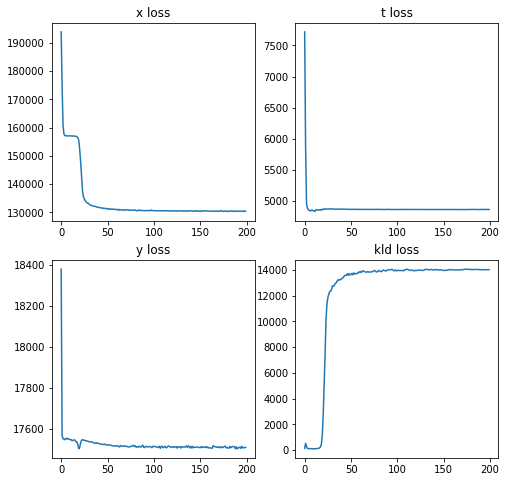

Total loss in the end:  166722.80883789062
Estimated causal effect: [0.03329109 0.32286519] true value: [0, 0.5]


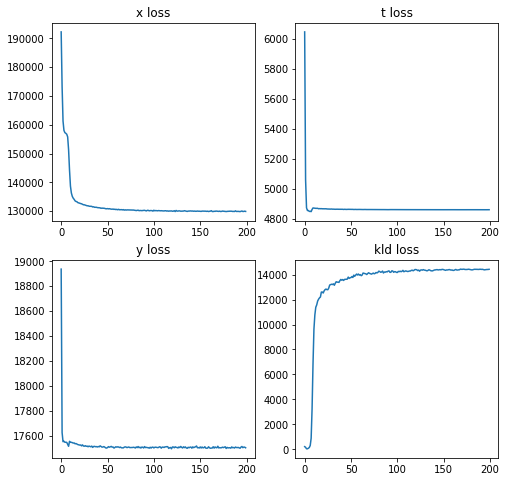

Total loss in the end:  166687.64770507812
Estimated causal effect: [0.03315733 0.322537  ] true value: [0, 0.5]


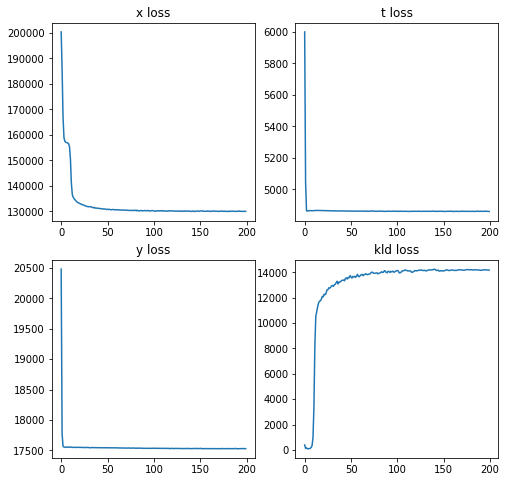

Total loss in the end:  166624.78637695312
Estimated causal effect: [0.03287197 0.32216918] true value: [0, 0.5]


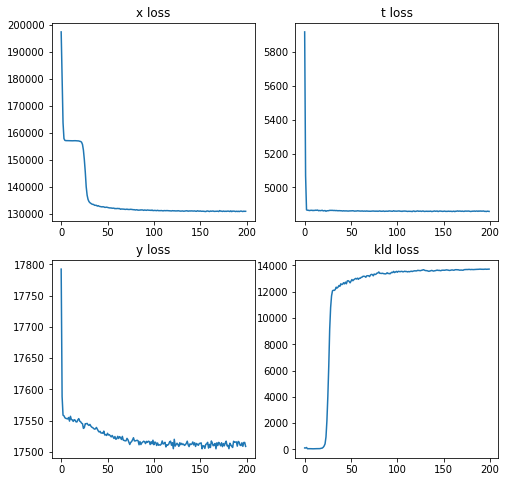

Total loss in the end:  166936.02392578125
Estimated causal effect: [0.03194024 0.32198867] true value: [0, 0.5]


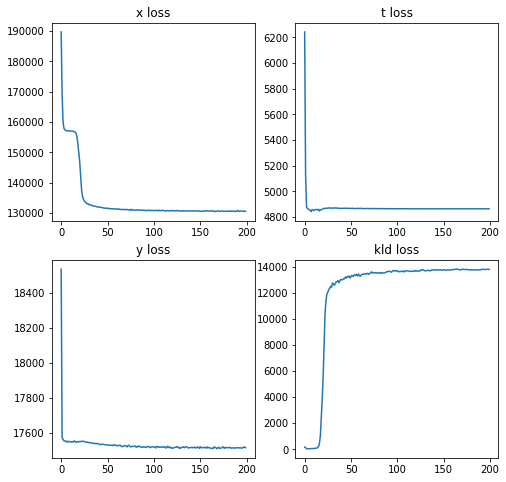

Total loss in the end:  166812.32788085938
Estimated causal effect: [0.03302277 0.3217015 ] true value: [0, 0.5]


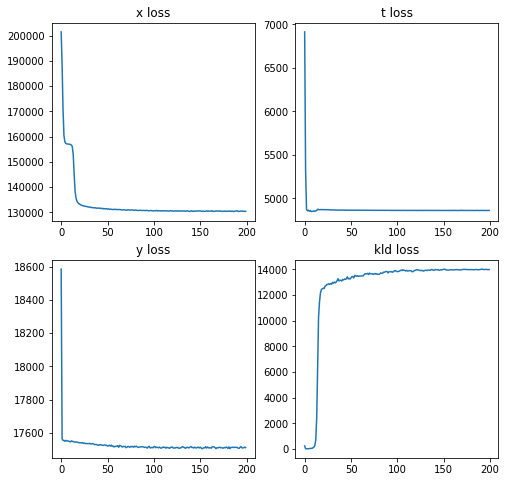

Total loss in the end:  166759.54809570312
Estimated causal effect: [0.03183937 0.32384887] true value: [0, 0.5]


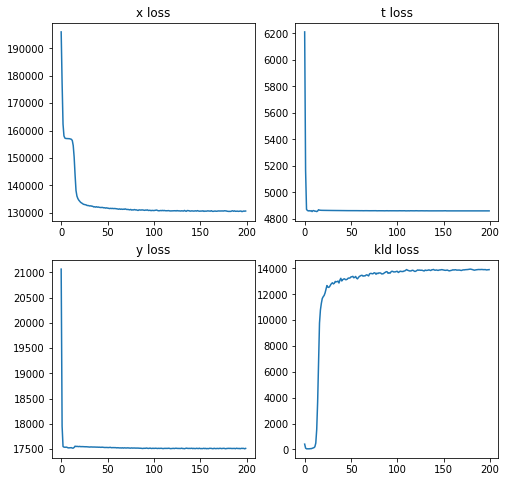

Total loss in the end:  166905.22631835938
Estimated causal effect: [0.03157416 0.32238802] true value: [0, 0.5]


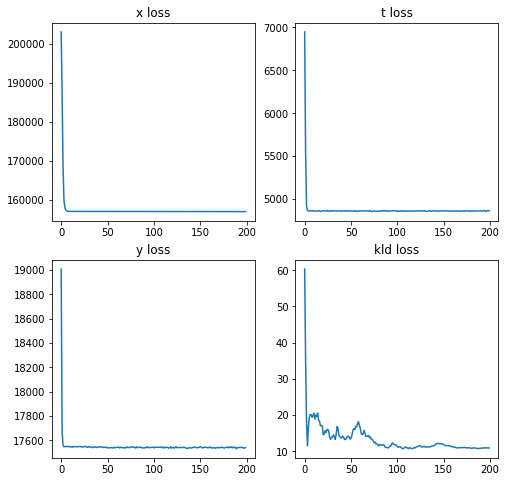

Total loss in the end:  179449.87353515625
Estimated causal effect: [0.03555277 0.3215256 ] true value: [0, 0.5]


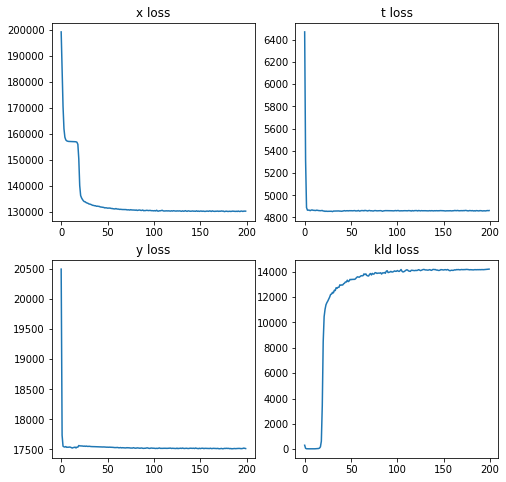

Total loss in the end:  166964.712890625
Estimated causal effect: [0.03110458 0.3220239 ] true value: [0, 0.5]


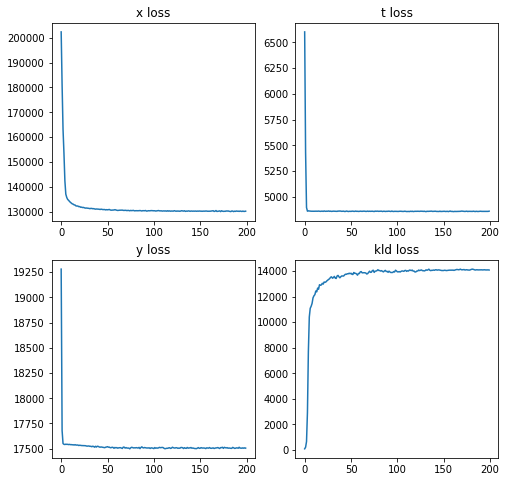

Total loss in the end:  166612.12084960938
Estimated causal effect: [0.03376828 0.32256874] true value: [0, 0.5]


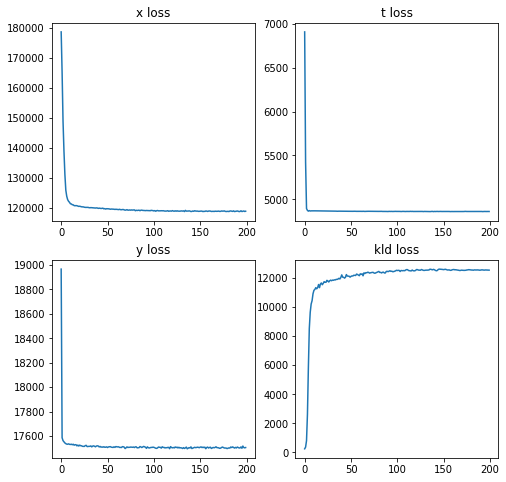

Total loss in the end:  153818.75634765625
Estimated causal effect: [0.03205172 0.3223497 ] true value: [0, 0.5]


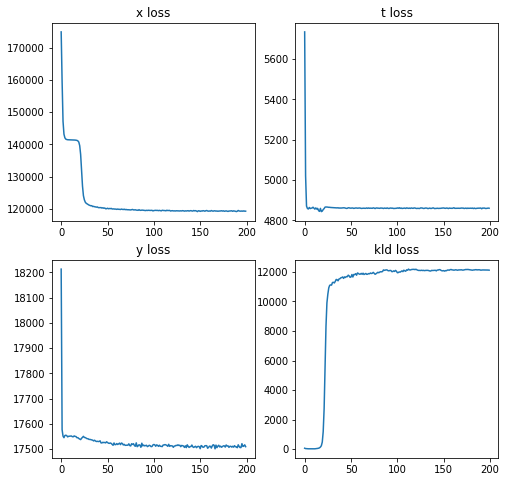

Total loss in the end:  153738.15771484375
Estimated causal effect: [0.03132974 0.32169482] true value: [0, 0.5]


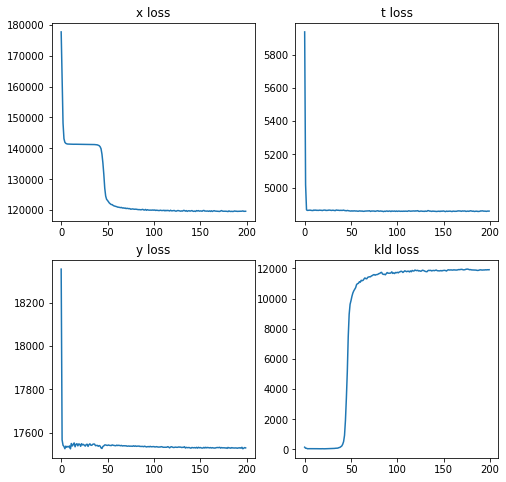

Total loss in the end:  153938.09326171875
Estimated causal effect: [0.03463593 0.32013747] true value: [0, 0.5]


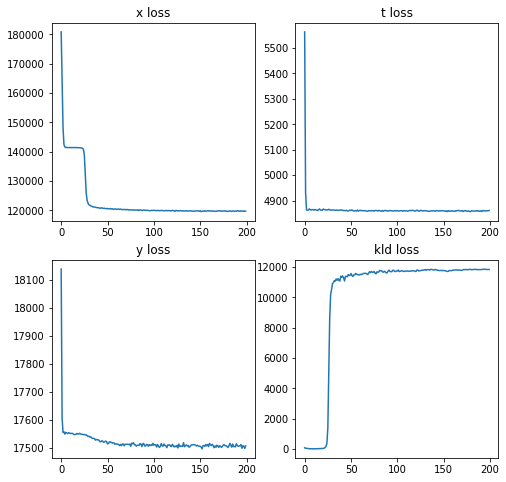

Total loss in the end:  153909.736328125
Estimated causal effect: [0.03249825 0.32274884] true value: [0, 0.5]


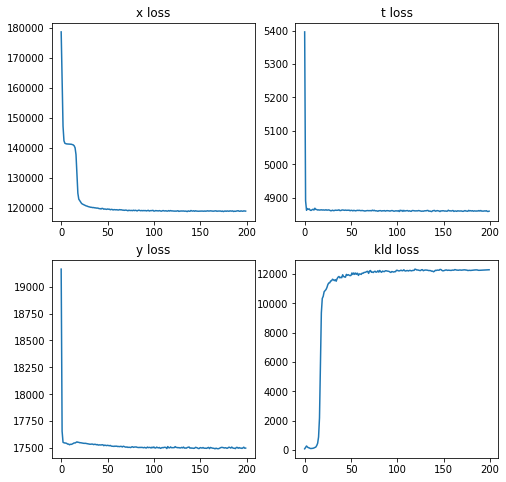

Total loss in the end:  153528.21557617188
Estimated causal effect: [0.03253647 0.32373065] true value: [0, 0.5]


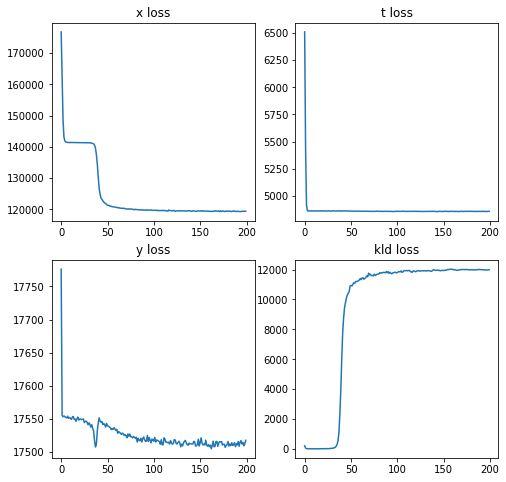

Total loss in the end:  153736.46411132812
Estimated causal effect: [0.03149285 0.32172146] true value: [0, 0.5]


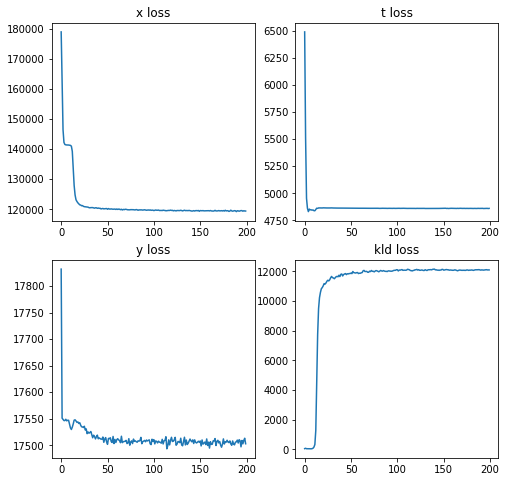

Total loss in the end:  153869.21752929688
Estimated causal effect: [0.03205144 0.32220775] true value: [0, 0.5]


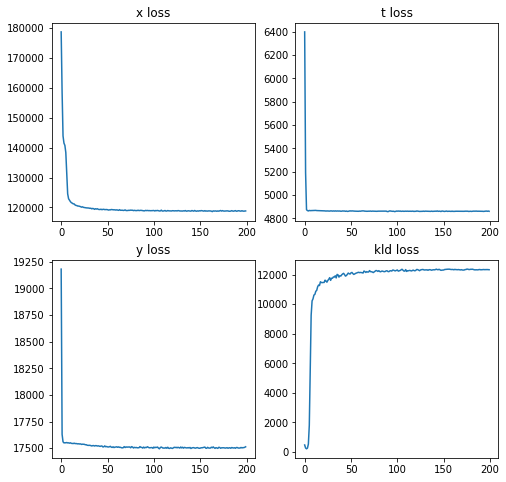

Total loss in the end:  153540.046875
Estimated causal effect: [0.03237934 0.32322586] true value: [0, 0.5]


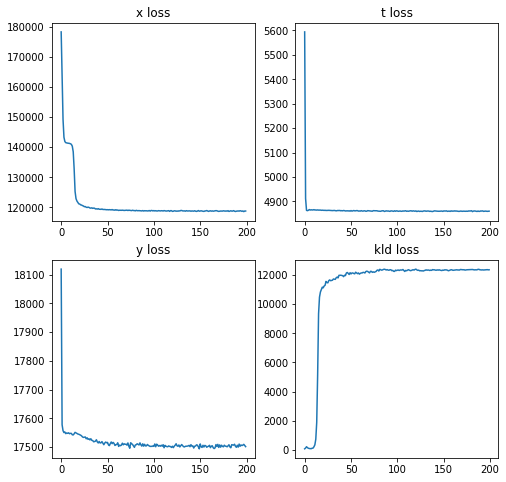

Total loss in the end:  153512.71142578125
Estimated causal effect: [0.03313204 0.32153529] true value: [0, 0.5]


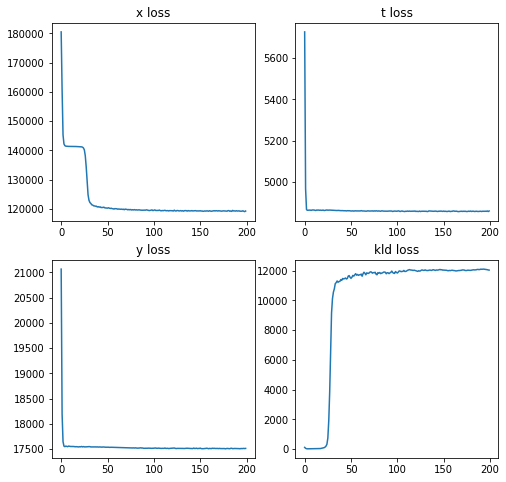

Total loss in the end:  153697.24169921875
Estimated causal effect: [0.03192489 0.32197413] true value: [0, 0.5]


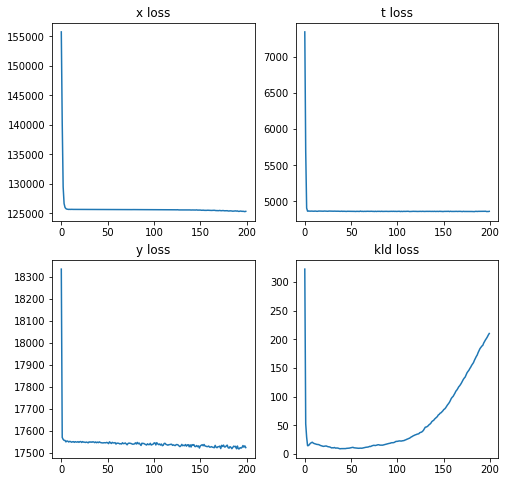

Total loss in the end:  147936.26928710938
Estimated causal effect: [0.03429211 0.32261616] true value: [0, 0.5]


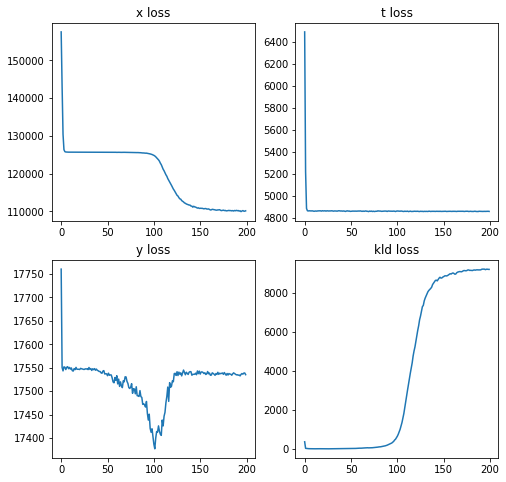

Total loss in the end:  141718.53100585938
Estimated causal effect: [0.03313813 0.32932404] true value: [0, 0.5]


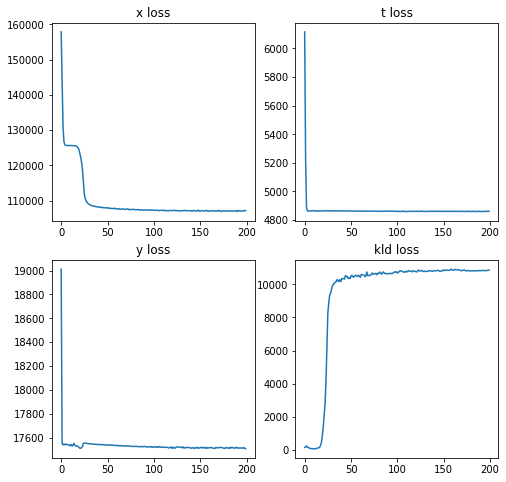

Total loss in the end:  140445.07373046875
Estimated causal effect: [0.03180944 0.32148078] true value: [0, 0.5]


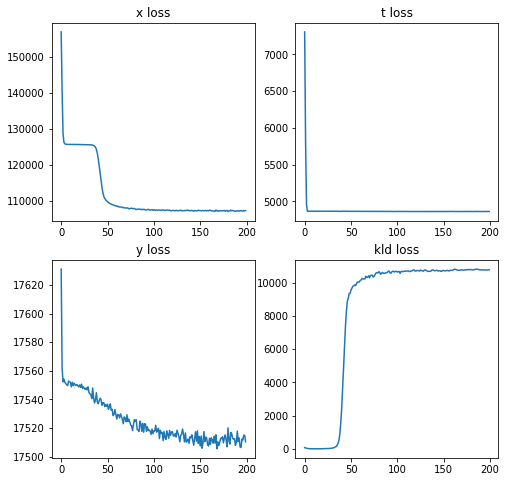

Total loss in the end:  140479.22607421875
Estimated causal effect: [0.03251722 0.32286674] true value: [0, 0.5]


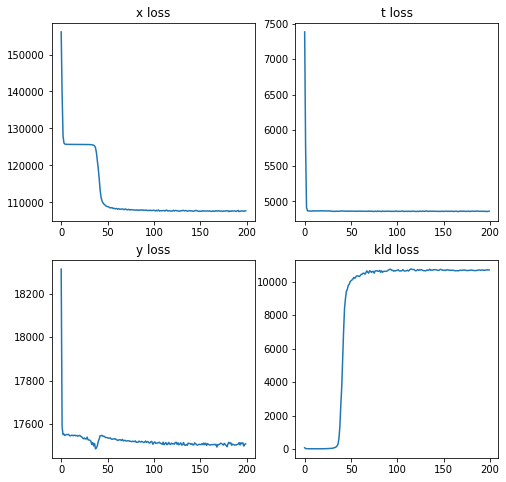

Total loss in the end:  140741.62451171875
Estimated causal effect: [0.03048702 0.32233179] true value: [0, 0.5]


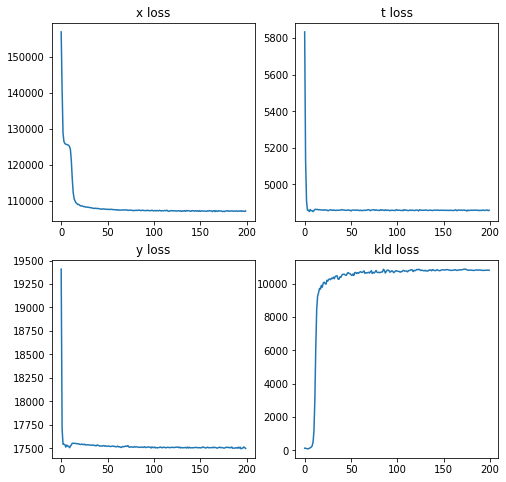

Total loss in the end:  140332.46166992188
Estimated causal effect: [0.03188063 0.32187539] true value: [0, 0.5]


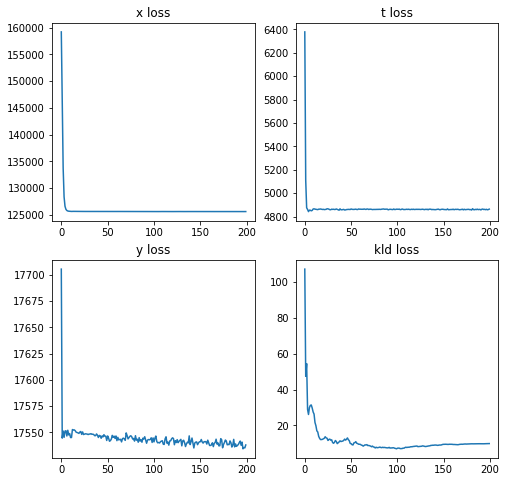

Total loss in the end:  148044.32104492188
Estimated causal effect: [0.03712018 0.32205525] true value: [0, 0.5]


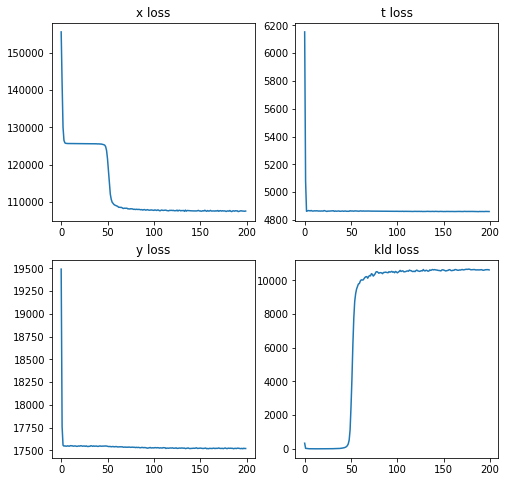

Total loss in the end:  140621.646484375
Estimated causal effect: [0.03135886 0.32180819] true value: [0, 0.5]


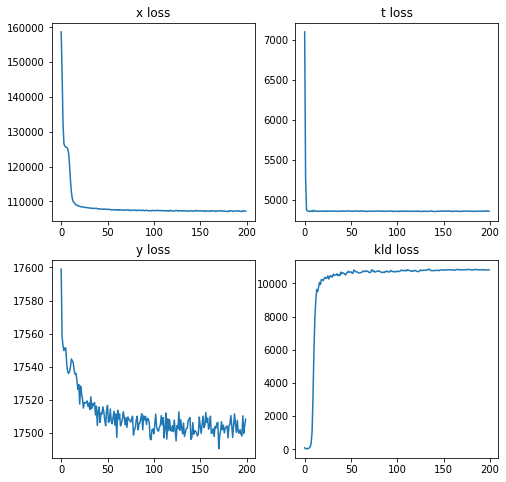

Total loss in the end:  140399.98071289062
Estimated causal effect: [0.03251449 0.32333794] true value: [0, 0.5]


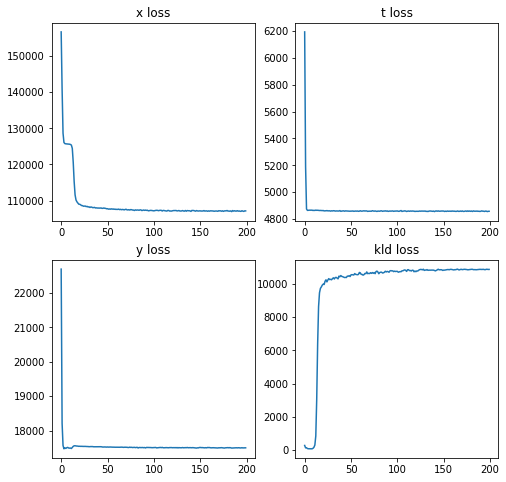

Total loss in the end:  140334.01123046875
Estimated causal effect: [0.0316998  0.32182306] true value: [0, 0.5]


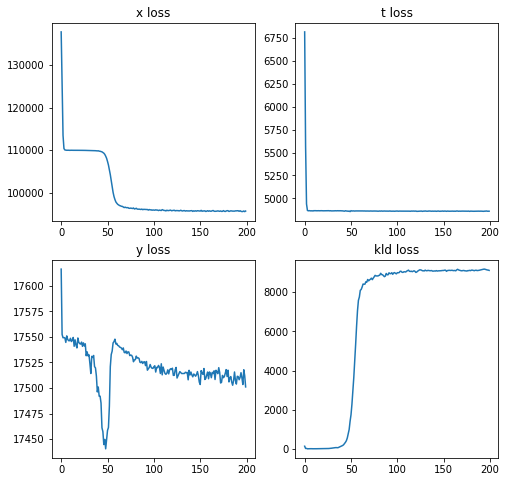

Total loss in the end:  127100.90087890625
Estimated causal effect: [0.03068481 0.32194066] true value: [0, 0.5]


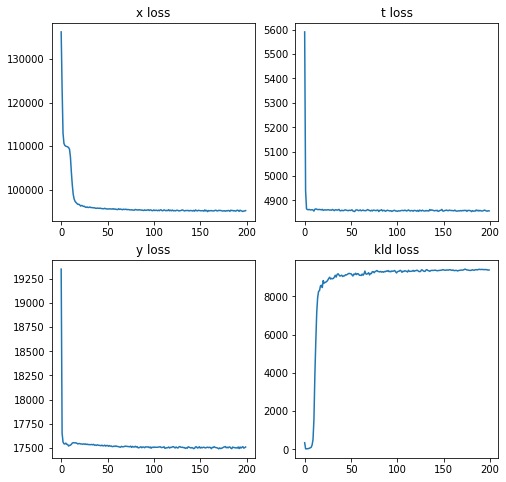

Total loss in the end:  126929.73461914062
Estimated causal effect: [0.03278546 0.32350326] true value: [0, 0.5]


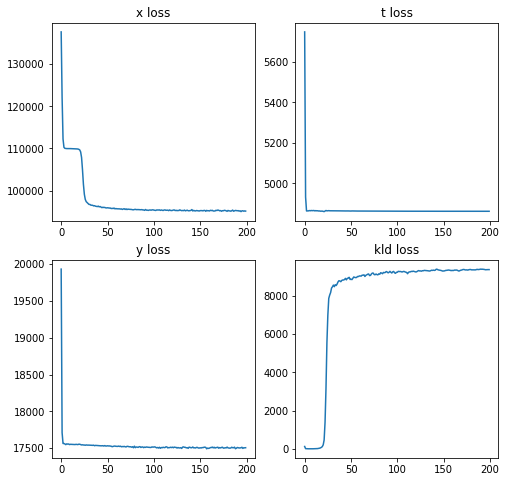

Total loss in the end:  126847.26098632812
Estimated causal effect: [0.03354525 0.3238906 ] true value: [0, 0.5]


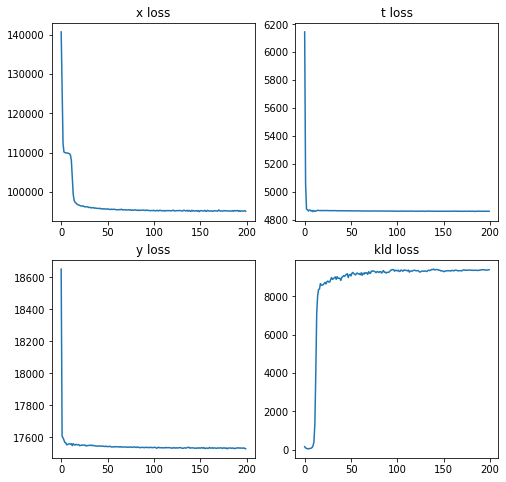

Total loss in the end:  126870.09521484375
Estimated causal effect: [0.03295469 0.32205671] true value: [0, 0.5]


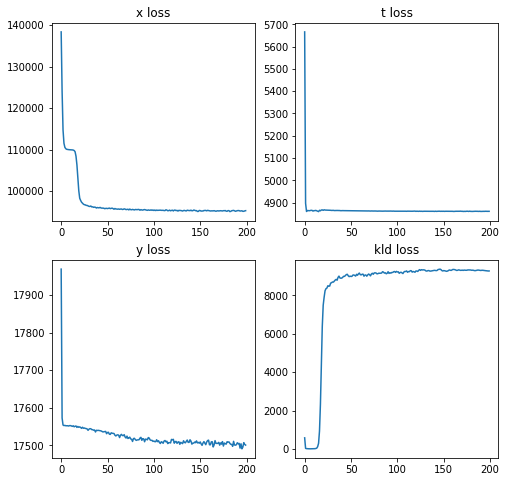

Total loss in the end:  126939.40747070312
Estimated causal effect: [0.03275613 0.32218796] true value: [0, 0.5]


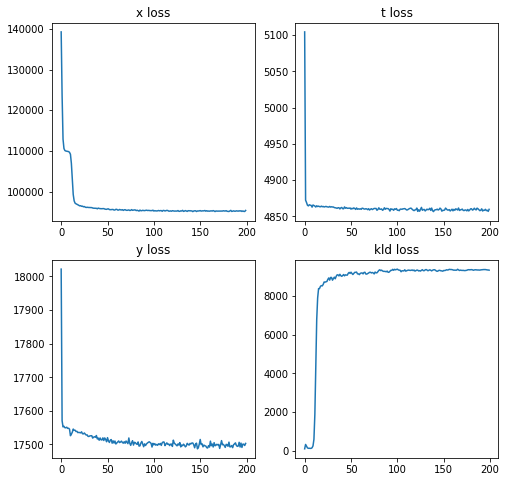

Total loss in the end:  127066.72875976562
Estimated causal effect: [0.03125264 0.32488996] true value: [0, 0.5]


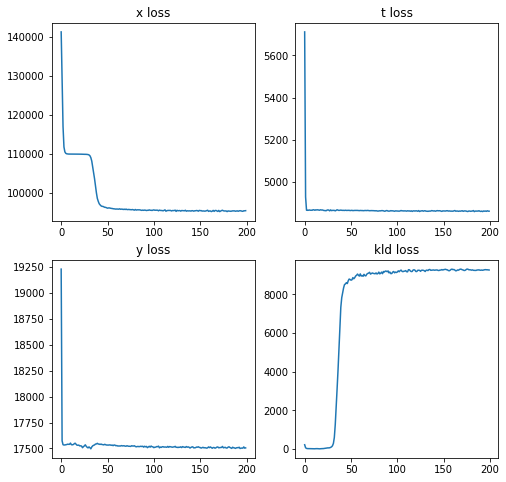

Total loss in the end:  127123.66943359375
Estimated causal effect: [0.03012757 0.32103661] true value: [0, 0.5]


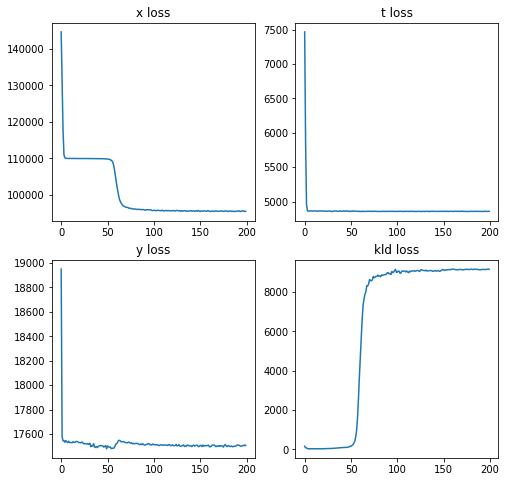

Total loss in the end:  127004.48315429688
Estimated causal effect: [0.03055951 0.32131988] true value: [0, 0.5]


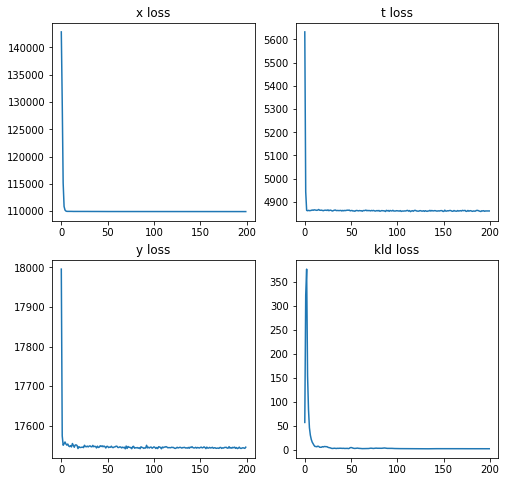

Total loss in the end:  132341.90600585938
Estimated causal effect: [0.03564065 0.3225238 ] true value: [0, 0.5]


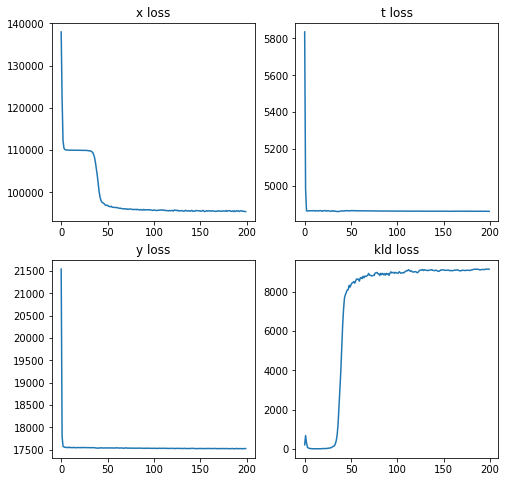

Total loss in the end:  126939.55053710938
Estimated causal effect: [0.03339642 0.32164598] true value: [0, 0.5]


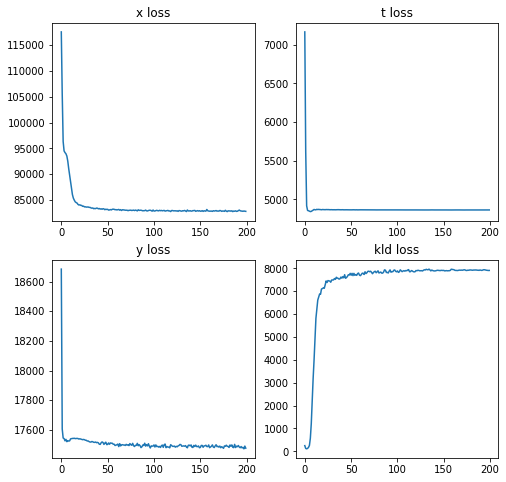

Total loss in the end:  113054.12939453125
Estimated causal effect: [0.03183849 0.32267699] true value: [0, 0.5]


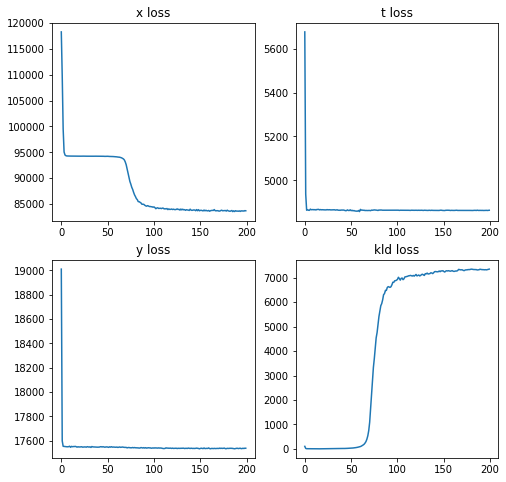

Total loss in the end:  113425.49951171875
Estimated causal effect: [0.03441548 0.32242614] true value: [0, 0.5]


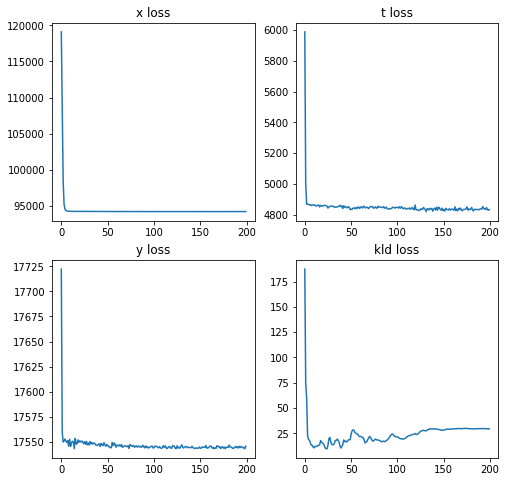

Total loss in the end:  116632.36669921875
Estimated causal effect: [0.03553449 0.325095  ] true value: [0, 0.5]


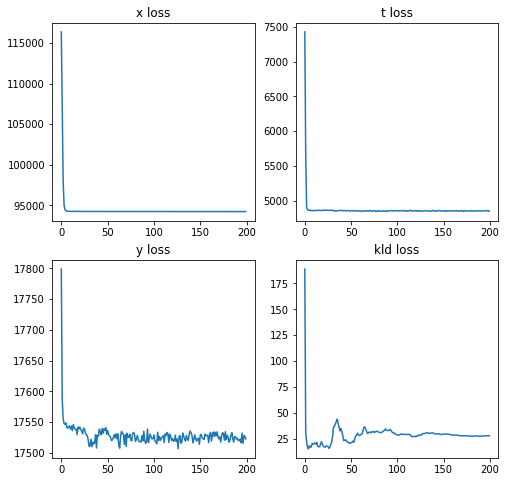

Total loss in the end:  116633.22387695312
Estimated causal effect: [0.03412816 0.32754877] true value: [0, 0.5]


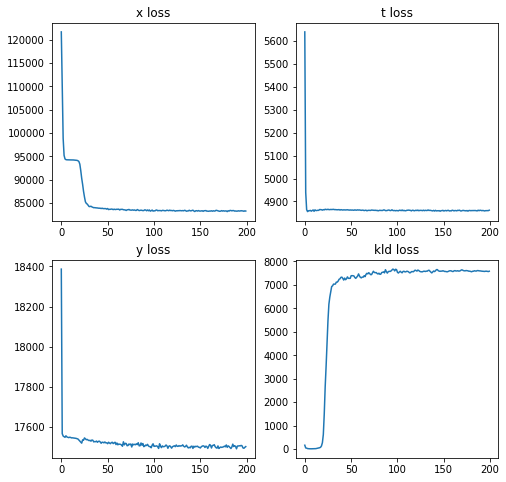

Total loss in the end:  113213.38916015625
Estimated causal effect: [0.03226586 0.32252961] true value: [0, 0.5]


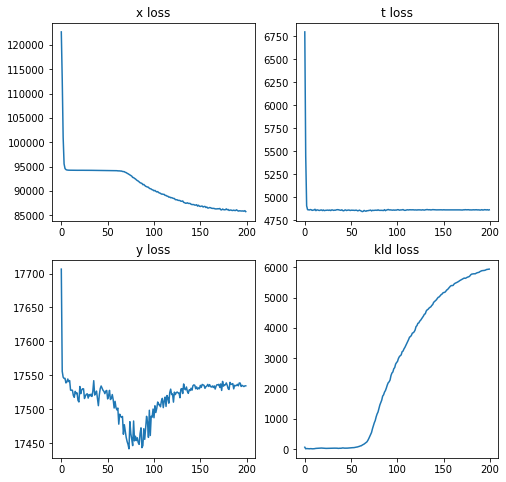

Total loss in the end:  114100.9755859375
Estimated causal effect: [0.03602634 0.31338307] true value: [0, 0.5]


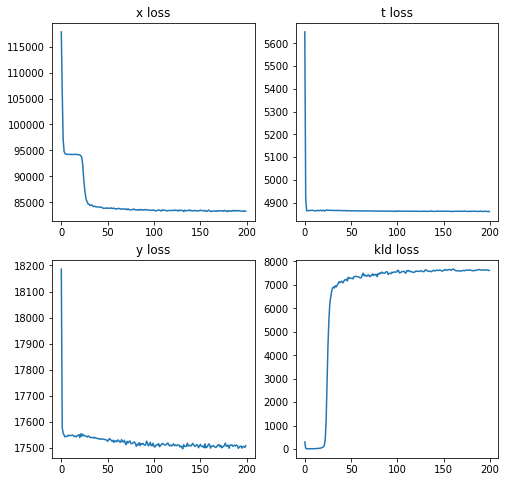

Total loss in the end:  113268.71313476562
Estimated causal effect: [0.03077294 0.32301551] true value: [0, 0.5]


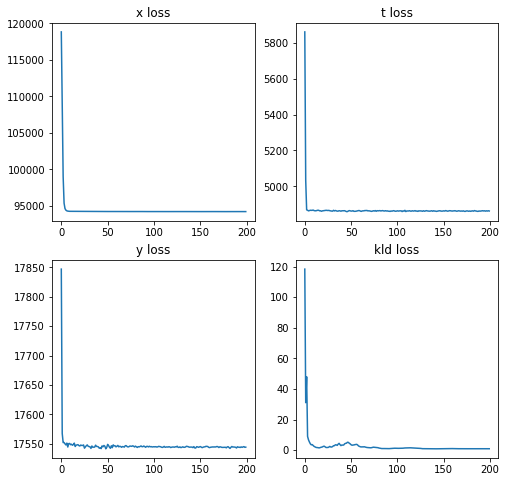

Total loss in the end:  116635.36743164062
Estimated causal effect: [0.03571922 0.32224226] true value: [0, 0.5]


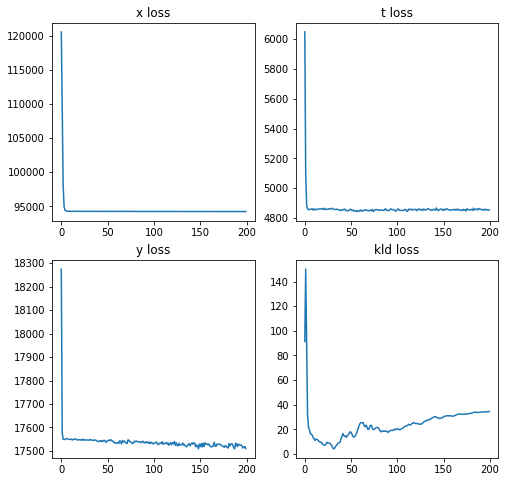

Total loss in the end:  116615.61328125
Estimated causal effect: [0.03699736 0.31570625] true value: [0, 0.5]


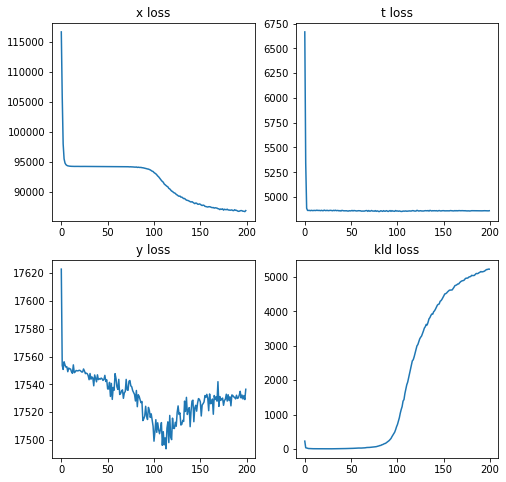

Total loss in the end:  114504.11303710938
Estimated causal effect: [0.03851496 0.32821691] true value: [0, 0.5]


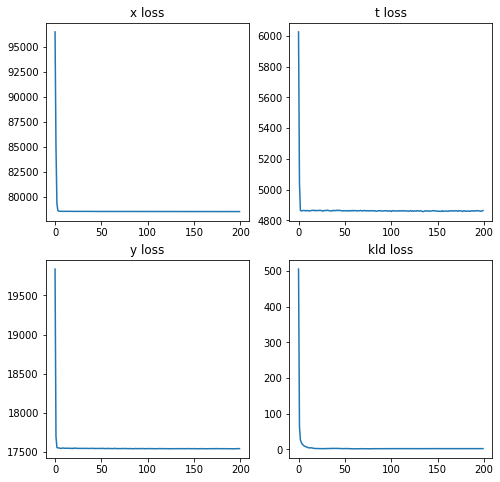

Total loss in the end:  100931.78576660156
Estimated causal effect: [0.03566471 0.3225587 ] true value: [0, 0.5]


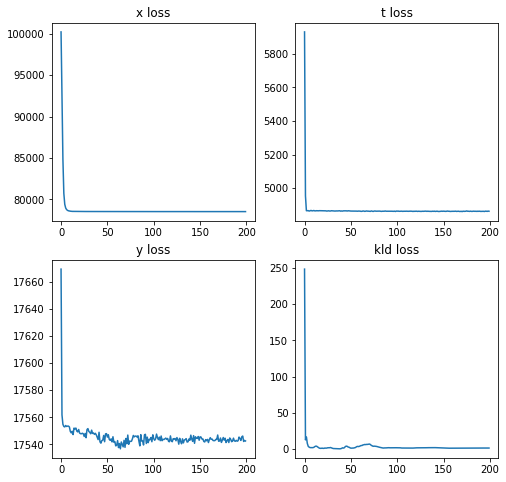

Total loss in the end:  100928.65002441406
Estimated causal effect: [0.03571437 0.32257399] true value: [0, 0.5]


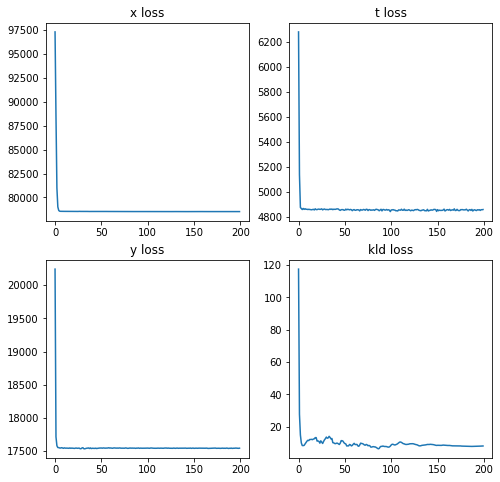

Total loss in the end:  100935.10119628906
Estimated causal effect: [0.03576985 0.32253298] true value: [0, 0.5]


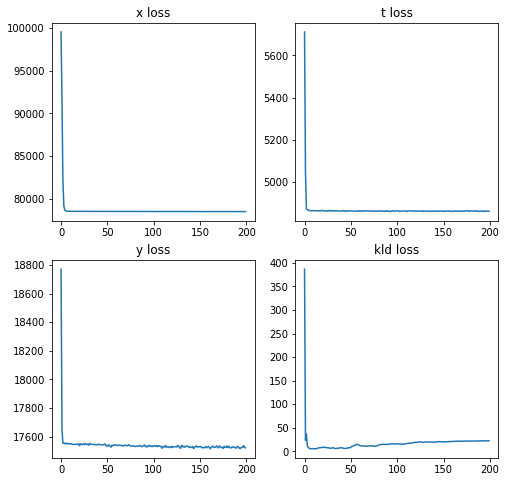

Total loss in the end:  100920.31945800781
Estimated causal effect: [0.03599971 0.32329798] true value: [0, 0.5]


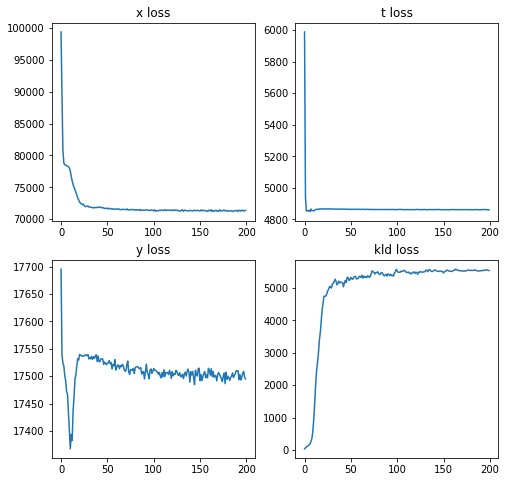

Total loss in the end:  99260.44067382812
Estimated causal effect: [0.03380526 0.32121786] true value: [0, 0.5]


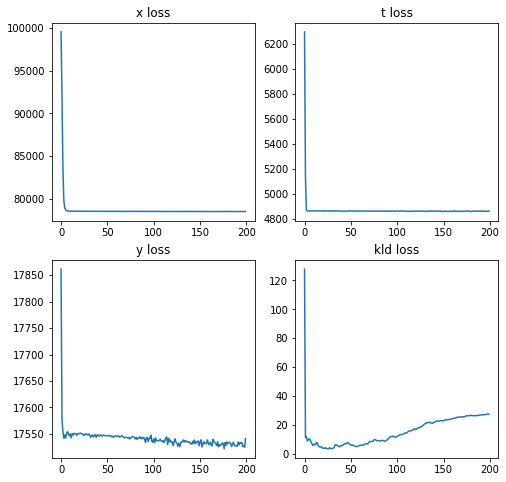

Total loss in the end:  100940.36328125
Estimated causal effect: [0.03638519 0.32250935] true value: [0, 0.5]


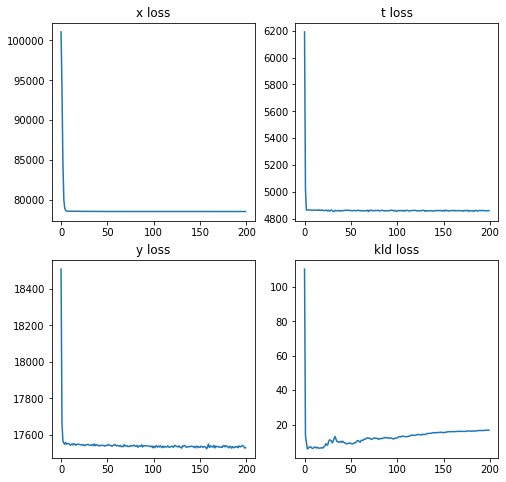

Total loss in the end:  100928.44494628906
Estimated causal effect: [0.03588131 0.32082102] true value: [0, 0.5]


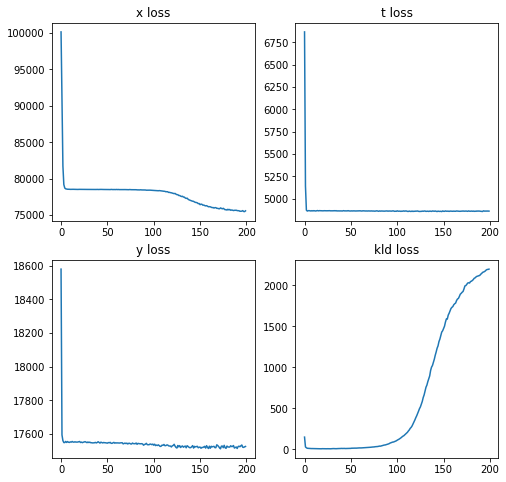

Total loss in the end:  100175.662109375
Estimated causal effect: [0.03475085 0.32655933] true value: [0, 0.5]


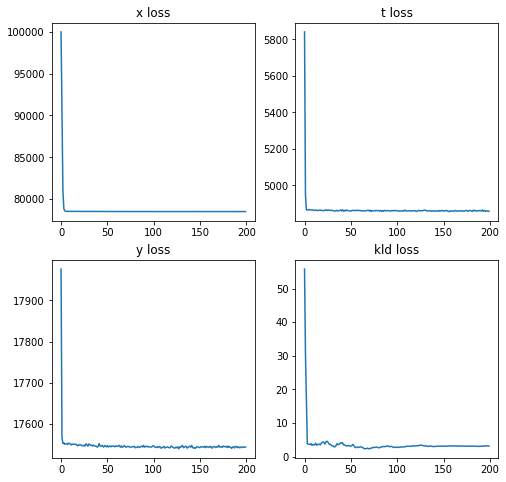

Total loss in the end:  100929.48388671875
Estimated causal effect: [0.03504395 0.32298034] true value: [0, 0.5]


KeyboardInterrupt: 

In [185]:
# Run the model


models, losses = run_model_for_predef_datasets(datasets, param_times, main_folder, sub_folder_model, 
                                               BATCH_SIZE, track_function, true_value, 
                                               device, train_arguments, labels, data_labels)